### Import Packages
Numpy and pandas provide data computation and structured processing capabilities; Matplotlib is used to visualize model evaluation results (such as ROC/PR curves); The sklearn module implements the entire process of machine learning - ensuring data distribution balance through Stratified KFold stratified sampling, GridSearchCV searching for optimal hyperparameters, Pipeline integrating data standardization (StandardScaler) and model training, metrics calculating key indicators such as accuracy, recall, F1, AUC, etc; RandomForestClassifier and LogisticRegression provide non-linear classification based on tree ensembles and highly interpretable linear classification capabilities, respectively.

In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_curve, precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import random
from scipy.stats import ttest_rel

### Preprocess Data
We ensure the reproducibility of the experiment by setting random seeds and defines a data loading function: using pd.read_csv to read CSV files, extract feature columns and convert them to floating point type. It should be noted that binary processing may lose information on the severity of the disease, and the code may not handle possible missing values. Relevant logic needs to be supplemented according to actual needs.

In [9]:

np.random.seed(42)
random.seed(42)

def load_data(file_path):
    data = pd.read_csv(file_path, header=None, sep=',')
    X = data.iloc[:, :-1].astype(float)  
    y = data.iloc[:, -1].map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})  
    return X, y

### Define Models and use Hyperparameter Search Space
The code is configured with detailed hyperparameter search ranges for random forest and logistic regression models, supporting subsequent grid search (GridSearchCV) to find the optimal parameter combination. Random forest focuses on tree structure related parameters, while logistic regression focuses on regularization strength and optimization algorithms.

In [12]:

models = {
    'Random Forest': {
        'class': RandomForestClassifier,
        'param_grid': {
            'n_estimators': [50, 100, 200],  
            'max_depth': [4, 6, 8],          
            'min_samples_split': [2, 5, 10],  
            'bootstrap': [True, False],       
            'random_state': [42]            
        }
    },
    'Logistic Regression': {
        'class': LogisticRegression,
        'param_grid': {
            'C': [0.01, 0.1, 1, 10],        
            'max_iter': [500, 1000, 2000],  
            'solver': ['lbfgs', 'liblinear']  
        }
    }
}

### Use Hyperparameter Search Function
We wrote the function that automatically configures the search process based on the model type (logistic regression/random forest), returns the optimal model instance and corresponding parameters, and supports subsequent model evaluation and comparison.

In [15]:


def hyperparameter_search(model_name, model_class, param_grid, X_train, y_train):
    if model_name == 'Logistic Regression':
        pipeline = Pipeline([
            ('scaler', StandardScaler()),   
            ('model', model_class(random_state=42)) #make sure the reprod...
        ])
        search = GridSearchCV(pipeline, {'model__' + k: v for k, v in param_grid.items()},
                              cv=3, scoring='roc_auc', n_jobs=-1)
    else:
        search = GridSearchCV(model_class(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1) #make sure the reprod...
    
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

### Train and Evaluate two Models
This code implements the training and evaluation of machine learning models through hierarchical cross validation: firstly, the training set and validation set are divided, and the hyperparameter search function is called to obtain the optimal model; Then calculate the recall rate, F1, AUC and other indicators, and store the ROC/PR curve data for each fold; Finally, summarize the average indicators, output the model performance, and return detailed results for subsequent analysis and visualization. 

In [18]:


def train_and_evaluate(model_name, model_class, param_grid, X, y, cv):
    print(f"\n=== 训练 {model_name} ===")
    metrics_results = {'per_fold': [], 'mean_metrics': {}}  
    

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
      
        X_train, X_val = X.iloc[train_idx].reset_index(drop=True), X.iloc[val_idx].reset_index(drop=True)  
        y_train, y_val = y.iloc[train_idx].reset_index(drop=True), y.iloc[val_idx].reset_index(drop=True)

        # 超参数搜索
        best_model, best_params = hyperparameter_search(model_name, model_class, param_grid, X_train, y_train)
        
        # 预测与指标计算
        y_proba = best_model.predict_proba(X_val)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)
        
        # 计算评估指标（召回率、F1等）
        recall = recall_score(y_val, y_pred)
        ap = average_precision_score(y_val, y_proba)
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba)
        precision = precision_score(y_val, y_pred)
        
        # 存储ROC/PR曲线数据
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        precision_list, recall_list, _ = precision_recall_curve(y_val, y_proba)
        metrics_results['per_fold'].append({
            'recall': recall, 'ap': ap, 'f1': f1,
            'auc': auc, 'precision': precision, 'roc': (fpr, tpr), 'pr': (precision_list, recall_list)
        })
        print(f"Fold {fold_idx+1}: Best Params = {best_params}, Recall = {recall:.3f}, AP = {ap:.3f}, F1 = {f1:.3f}, AUC = {auc:.3f}, Precision = {precision:.3f} ")
    
    # 计算平均指标
    for metric in ['recall', 'ap', 'f1', 'auc', 'precision']:
        values = [fold[metric] for fold in metrics_results['per_fold']]
        metrics_results['mean_metrics'][metric] = (np.mean(values), np.std(values))
    
    print("\n=== 平均评估指标 ===")
    for metric, (mean, std) in metrics_results['mean_metrics'].items():
        print(f"{metric.upper()}: {mean:.3f} ± {std:.3f}")
    
    return metrics_results

### Display the Results
This code defines a visualization function plot_per_fold_curves for plotting the ROC and PR curves for each fold: the left subplot shows the ROC curve and its AUC value, the right subplot shows the PR curve and its average precision (AP), and baseline is added as a reference; Finally adjust the layout and display the image, visually compare the performance of the model on different folds, and evaluate its stability and generalization ability. 

In [21]:

# 结果可视化
def plot_per_fold_curves(model_name, per_fold_data):
    plt.figure(figsize=(15, 8))
    
    
    plt.subplot(1, 2, 1)
    for i, fold in enumerate(per_fold_data):
        fpr, tpr = fold['roc']
        plt.plot(fpr, tpr, lw=1.5, linestyle='--', label=f'Fold {i+1} (AUC={fold["auc"]:.2f})')
    plt.plot([0,1], [0,1], 'k--', lw=2) #
    plt.title(f'ROC Curves - {model_name}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i, fold in enumerate(per_fold_data):
        precision, recall = fold['pr']
        plt.plot(recall, precision, lw=1.5, linestyle='--', label=f'Fold {i+1} (AP={fold["ap"]:.2f})')
    plt.plot([0,1], [1,0], 'k--', lw=2) # 理想情况基线
    plt.title(f'PR Curves - {model_name}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [24]:


def compare_models_with_ttest(results_rf, results_lr):
    """
    Perform paired t-test to compare the evaluation metrics of two models across multiple folds.
    
    :param results_rf: Cross-validation evaluation results of Random Forest
    :param results_lr: Cross-validation evaluation results of Logistic Regression
    """
    priority_metrics = ['f1', 'recall', 'precision', 'auc', 'ap']
    all_metrics = ['f1', 'recall', 'precision', 'auc', 'ap']  # All stored evaluation metrics
    
    print("\n=== Statistical Significance Test (Paired t-test) ===")
    
    for metric in all_metrics:
        rf_scores = [fold[metric] for fold in results_rf['per_fold']]
        lr_scores = [fold[metric] for fold in results_lr['per_fold']]
        
        t_stat, p_value = ttest_rel(rf_scores, lr_scores)
        result_str = f"{metric.upper()} - t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}"
        
        if p_value < 0.05:
            result_str += f" --> Result: {metric.upper()} shows a significant difference between the two models (p < 0.05)"
        else:
            result_str += f" --> Result: {metric.upper()} shows no significant difference between the two models (p >= 0.05)"
        
        if metric in priority_metrics:
            print("*", result_str)  # Highlight higher-priority metrics with *
        else:
            print(result_str)



### Run the process
At the end of this code, the process will be run and the outcome will be displayed. Firstly, load the data and set up 5-fold hierarchical cross validation. Then, traverse the predefined models (random forest and logistic regression) for training and evaluation. Finally, plot the ROC and PR curves for each fold to visualize the model performance, supporting multi model comparison and result analysis.


=== 训练 Random Forest ===
Fold 1: Best Params = {'bootstrap': True, 'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 50, 'random_state': 42}, Recall = 0.893, AP = 0.941, F1 = 0.862, AUC = 0.944, Precision = 0.833 
Fold 2: Best Params = {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}, Recall = 0.750, AP = 0.906, F1 = 0.792, AUC = 0.919, Precision = 0.840 
Fold 3: Best Params = {'bootstrap': True, 'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}, Recall = 0.667, AP = 0.808, F1 = 0.692, AUC = 0.821, Precision = 0.720 
Fold 4: Best Params = {'bootstrap': False, 'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}, Recall = 0.741, AP = 0.889, F1 = 0.816, AUC = 0.885, Precision = 0.909 
Fold 5: Best Params = {'bootstrap': True, 'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 42}, Recall = 0.778, AP = 0.930, F1 = 0.857, AUC = 0.922, Precisio

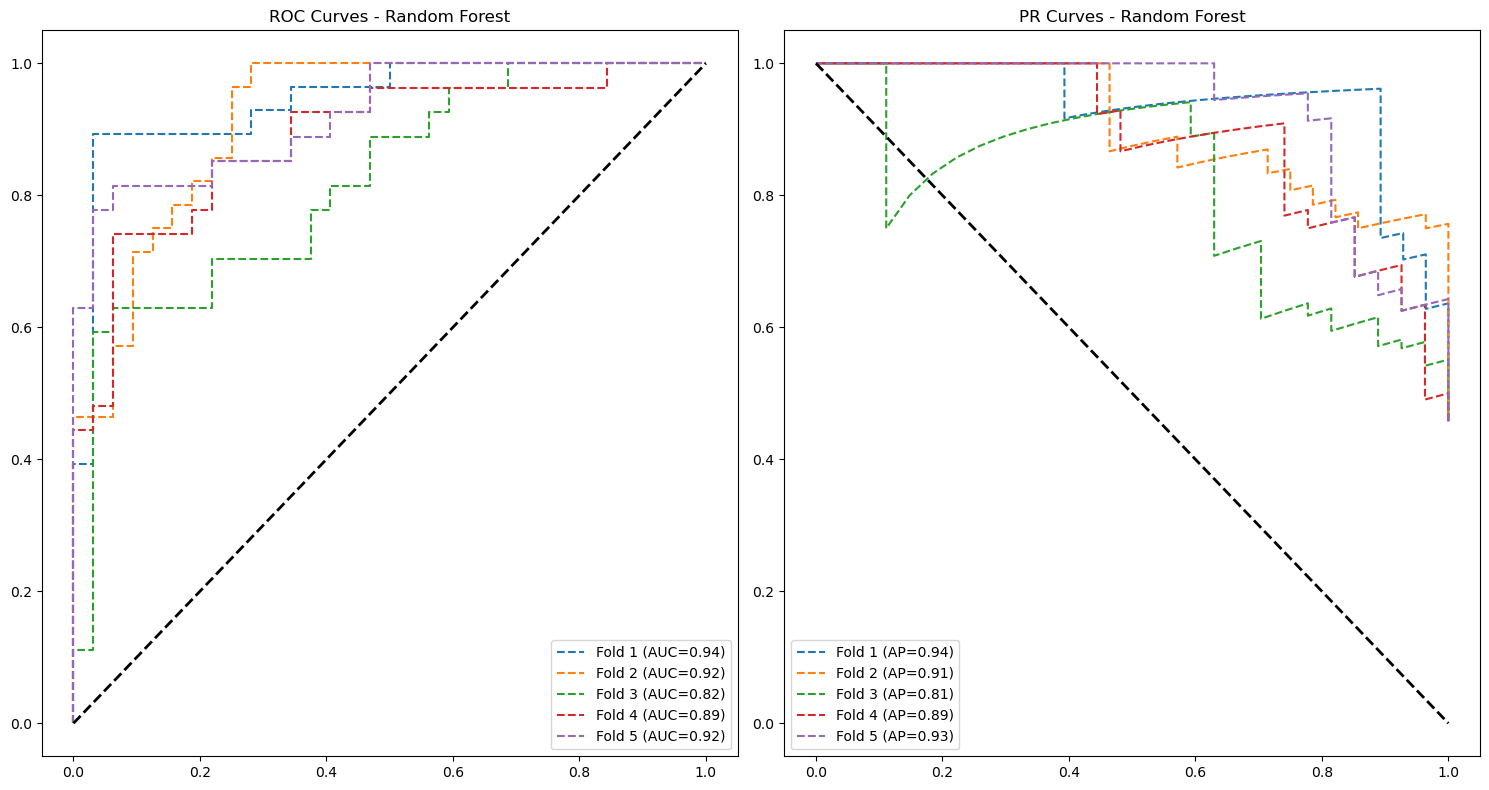

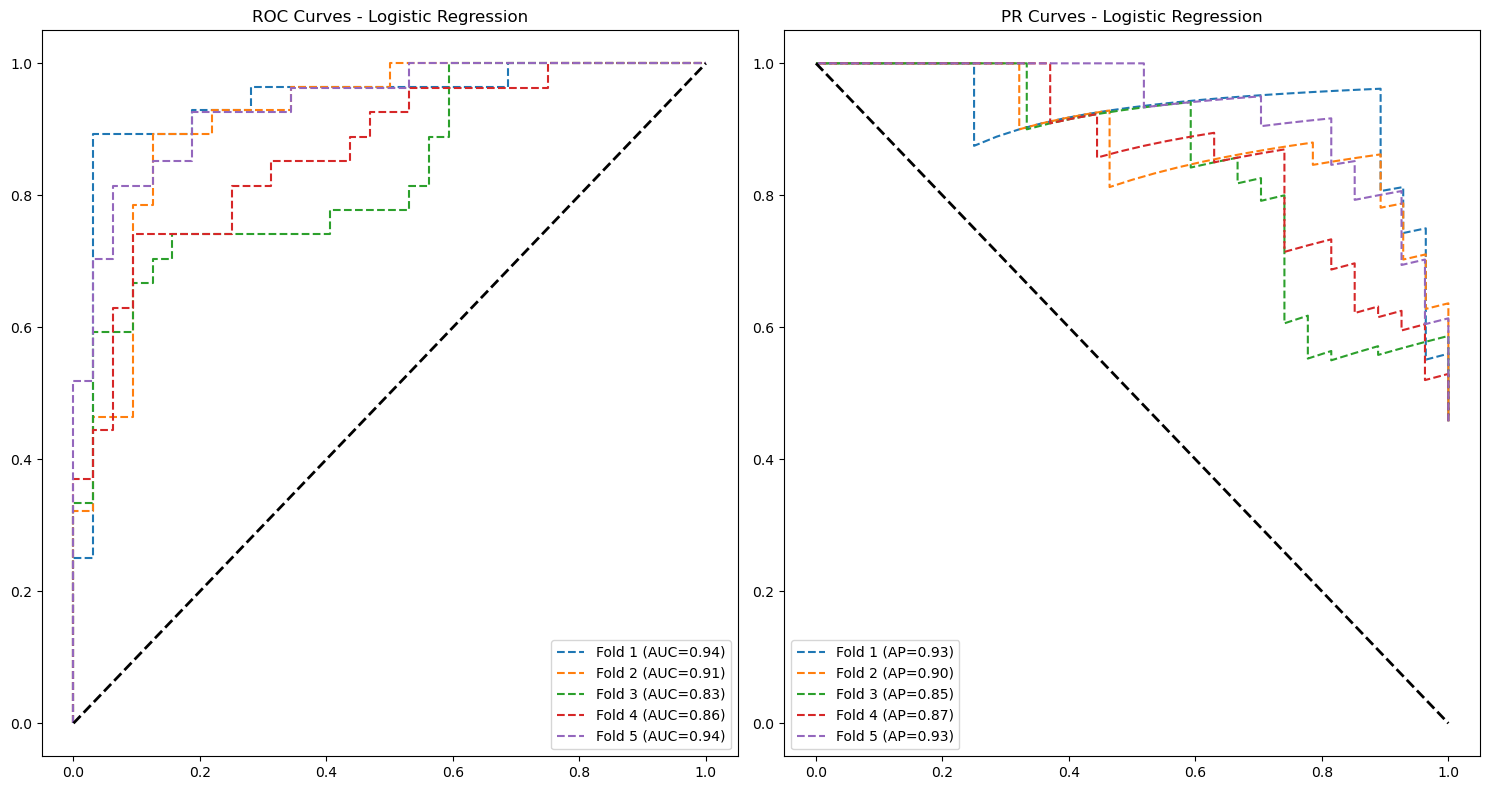


=== Statistical Significance Test (Paired t-test) ===
* F1 - t-statistic: -0.029, p-value: 0.978 --> Result: F1 shows no significant difference between the two models (p >= 0.05)
* RECALL - t-statistic: -0.357, p-value: 0.739 --> Result: RECALL shows no significant difference between the two models (p >= 0.05)
* PRECISION - t-statistic: 0.358, p-value: 0.738 --> Result: PRECISION shows no significant difference between the two models (p >= 0.05)
* AUC - t-statistic: 0.171, p-value: 0.873 --> Result: AUC shows no significant difference between the two models (p >= 0.05)
* AP - t-statistic: 0.030, p-value: 0.977 --> Result: AP shows no significant difference between the two models (p >= 0.05)


In [27]:

file_path = 'processed.cleveland.csv'
X, y = load_data(file_path)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_results = {name: train_and_evaluate(name, info['class'], info['param_grid'], X, y, cv) for name, info in models.items()}
for name, results in all_results.items():
    plot_per_fold_curves(name, results['per_fold'])

results_rf = all_results.get("Random Forest")  # Get results for Random Forest
results_lr = all_results.get("Logistic Regression")  # Get results for Logistic Regression

compare_models_with_ttest(results_rf, results_lr)
